In [11]:
import torch
from datasets import load_dataset, Dataset, DatasetDict
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.model_selection import train_test_split as sk_train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import re
import random
import numpy as np
import matplotlib.pyplot as plt
import os

Loading data from original dataset (train.jsonl)...
Loaded 1500 samples from original dataset.

Loading data from HC3 dataset (data/HC3.jsonl)...
Reached 750 samples for each class from data/HC3.jsonl. Stopping early.
From data/HC3.jsonl: Loaded 750 human samples, 750 AI samples.
Loaded 1500 samples from ELI5 dataset.

Total samples before shuffling: 3000
Human samples: 1500, AI samples: 1500
Total samples after shuffling: 3000
Training samples: 2400, Testing samples: 600
Train human: 1200, Train AI: 1200
Test human: 300, Test AI: 300

Tokenizing datasets...


Map: 100%|██████████| 600/600 [00:00<00:00, 6083.27 examples/s]
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Loading pre-trained model...

Starting BERT model training...


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
10,0.708100,0.679530,0.501667,0.630408,0.500982,0.850000
20,0.689900,0.671603,0.551667,0.641811,0.534368,0.803333
30,0.680400,0.660823,0.576667,0.650138,0.553991,0.786667
40,0.654400,0.644714,0.616667,0.659763,0.593085,0.743333
50,0.645500,0.621589,0.645000,0.664567,0.629851,0.703333
60,0.617400,0.587705,0.708333,0.691358,0.734082,0.653333
70,0.587200,0.569486,0.708333,0.691358,0.734082,0.653333
80,0.562800,0.524404,0.756667,0.693277,0.937500,0.550000
90,0.477000,0.512260,0.731667,0.686160,0.826291,0.586667
100,0.534700,0.502954,0.743333,0.731707,0.766423,0.700000



Generating training curves...
Training curves saved to ./training_visualizations\training_curves.png

Evaluating on local test set:


BERT Test Set → Acc: 0.8500, Prec: 0.7949, Rec: 0.9433, F1: 0.8628

Saving the fine-tuned model to ./bert_ai_detector_final...
Model and tokenizer saved to ./bert_ai_detector_final


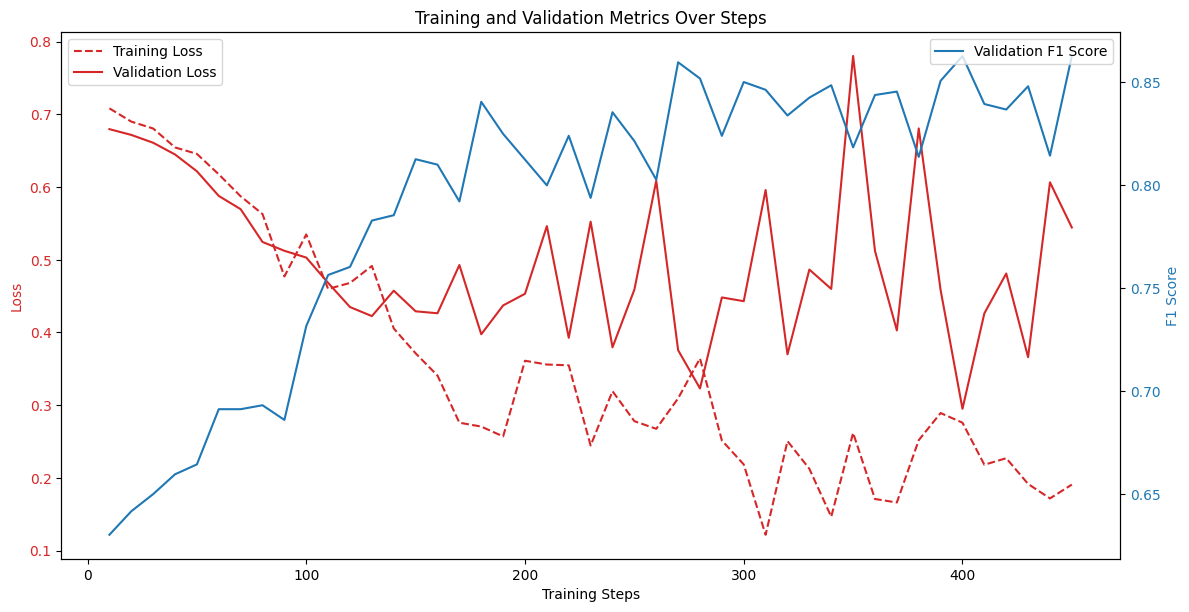

In [ ]:
def preprocess_text_for_bert(text):
    text = text.lower()
    text = re.sub(r"<[^>]+>", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

def get_data_from_jsonl_for_bert(path, n_per_split=10000):
    raw_ds = load_dataset("json", data_files=path, split=f"train[:{n_per_split*2}]")

    texts = []
    labels = []

    count_human = 0
    count_ai = 0

    for item in raw_ds:
        if item.get("real") and count_human < n_per_split:
            processed_text = preprocess_text_for_bert(item["real"])
            if len(processed_text.split()) >= 5:
                texts.append(processed_text)
                labels.append(0) # 0 for human
                count_human += 1
        if item.get("gpt2") and count_ai < n_per_split:
            processed_text = preprocess_text_for_bert(item["gpt2"])
            if len(processed_text.split()) >= 5:
                texts.append(processed_text)
                labels.append(1) # 1 for AI
                count_ai += 1
        if count_human >= n_per_split and count_ai >= n_per_split:
            break
            
    # Combine and shuffle
    combined = list(zip(texts, labels))
    random.shuffle(combined)
    texts, labels = zip(*combined)
    
    return list(texts), list(labels)

def get_data_from_eli5_format_jsonl(path, n_per_split=1000):
    try:
        raw_ds = load_dataset("json", data_files=path, split=f"train[:{n_per_split*10}]")
    except Exception as e:
        print(f"Warning: Could not slice dataset {path}. Loading full split. Error: {e}")
        raw_ds = load_dataset("json", data_files=path, split="train")


    texts = []
    labels = []

    count_human = 0
    count_ai = 0

    for item in raw_ds:
        # Process human answers
        if item.get("human_answers") and isinstance(item["human_answers"], list):
            for human_text in item["human_answers"]:
                if count_human < n_per_split:
                    processed_text = preprocess_text_for_bert(str(human_text))
                    if len(processed_text.split()) >= 5:
                        texts.append(processed_text)
                        labels.append(0) # 0 for human
                        count_human += 1
                else:
                    break

        # Process AI answers
        if item.get("chatgpt_answers") and isinstance(item["chatgpt_answers"], list):
            for ai_text in item["chatgpt_answers"]:
                if count_ai < n_per_split:
                    processed_text = preprocess_text_for_bert(str(ai_text))
                    if len(processed_text.split()) >= 5:
                        texts.append(processed_text)
                        labels.append(1) # 1 for AI
                        count_ai += 1
                else:
                    break

        if count_human >= n_per_split and count_ai >= n_per_split:
            print(f"Reached {n_per_split} samples for each class from {path}. Stopping early.")
            break

    print(f"From {path}: Loaded {count_human} human samples, {count_ai} AI samples.")
    return texts, labels

MODEL_NAME = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=256)

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="binary")
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

if __name__ == "__main__":
    # --- Parameters ---
    N_PER_SPLIT_ORIGINAL = 750
    N_PER_SPLIT_ELI5 = 750
    TEST_SPLIT_SIZE = 0.2
    RANDOM_SEED = 42
    MAX_SEQ_LENGTH = 256

    print("Loading data from original dataset...")
    texts_orig, labels_orig = get_data_from_jsonl_for_bert(
        "data/real-vs-gpt2-sentences.jsonl",
        n_per_split=N_PER_SPLIT_ORIGINAL
    )
    print(f"Loaded {len(texts_orig)} samples from original dataset.")

    ELI5_DATA_PATH = "data/HC3.jsonl"
    print(f"\nLoading data from HC3 dataset ({ELI5_DATA_PATH})...")
    texts_eli5, labels_eli5 = get_data_from_eli5_format_jsonl(
        ELI5_DATA_PATH,
        n_per_split=N_PER_SPLIT_ELI5
    )
    print(f"Loaded {len(texts_eli5)} samples from ELI5 dataset.")

    all_texts = texts_orig + texts_eli5
    all_labels = labels_orig + labels_eli5

    if not all_texts:
        raise ValueError("No data loaded. Check your file paths and data loading functions.")

    print(f"\nTotal samples before shuffling: {len(all_texts)}")
    print(f"Human samples: {all_labels.count(0)}, AI samples: {all_labels.count(1)}")

    # Shuffle the combined dataset
    combined_data = list(zip(all_texts, all_labels))
    random.seed(RANDOM_SEED)
    random.shuffle(combined_data)
    texts, labels = zip(*combined_data)
    texts = list(texts)
    labels = list(labels)

    print(f"Total samples after shuffling: {len(texts)}")

    train_texts, test_texts, train_labels, test_labels = sk_train_test_split(
        texts, labels, test_size=TEST_SPLIT_SIZE, random_state=RANDOM_SEED, stratify=labels
    )
    print(f"Training samples: {len(train_texts)}, Testing samples: {len(test_texts)}")
    print(f"Train human: {train_labels.count(0)}, Train AI: {train_labels.count(1)}")
    print(f"Test human: {test_labels.count(0)}, Test AI: {test_labels.count(1)}")


    # Create Hugging Face Dataset objects
    train_dataset_dict = {"text": train_texts, "label": train_labels}
    test_dataset_dict = {"text": test_texts, "label": test_labels}

    train_dataset = Dataset.from_dict(train_dataset_dict)
    test_dataset = Dataset.from_dict(test_dataset_dict)

    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
    def tokenize_function(examples):
        return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=MAX_SEQ_LENGTH)

    # Tokenize
    print("\nTokenizing datasets...")
    tokenized_train_dataset = train_dataset.map(tokenize_function, batched=True)
    tokenized_test_dataset = test_dataset.map(tokenize_function, batched=True)

    # Remove text column and set format
    tokenized_train_dataset = tokenized_train_dataset.remove_columns(["text"]).with_format("torch")
    tokenized_test_dataset = tokenized_test_dataset.remove_columns(["text"]).with_format("torch")

    # Load Model
    print("\nLoading pre-trained model...")
    model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)

    # Training Arguments
    training_args = TrainingArguments(
        output_dir="./bert_ai_detector_checkpoints",
        num_train_epochs=3,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=32,
        warmup_steps=500,
        weight_decay=0.01,
        logging_dir='./logs',
        logging_steps=10,
        eval_steps=10,
        save_steps=10,
        eval_strategy="steps",
        save_strategy="steps",
        load_best_model_at_end=True,
        metric_for_best_model="f1",
        report_to="tensorboard",
        fp16=torch.cuda.is_available(),
        seed=RANDOM_SEED
    )

    # Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_train_dataset,
        eval_dataset=tokenized_test_dataset,
        compute_metrics=compute_metrics,
    )

    # Train
    print("\nStarting BERT model training...")
    trainer.train()


    print("\nGenerating training curves...")
    log_history = trainer.state.log_history

    # Prepare lists for plotting
    train_steps_loss = []
    train_loss_values = []
    eval_steps_metrics = []
    eval_loss_values = []
    eval_f1_values = []
    eval_accuracy_values = []

    for log_entry in log_history:
        if 'loss' in log_entry and 'learning_rate' in log_entry:
            train_steps_loss.append(log_entry['step'])
            train_loss_values.append(log_entry['loss'])
        elif 'eval_loss' in log_entry:
            eval_steps_metrics.append(log_entry['step']) 
            eval_loss_values.append(log_entry['eval_loss'])
            if 'eval_f1' in log_entry:
                eval_f1_values.append(log_entry['eval_f1'])
            if 'eval_accuracy' in log_entry:
                eval_accuracy_values.append(log_entry['eval_accuracy'])

    output_plot_dir = "./training_visualizations"
    os.makedirs(output_plot_dir, exist_ok=True)
    plot_save_path = os.path.join(output_plot_dir, "training_curves.png")

    fig, ax1 = plt.subplots(figsize=(12, 6))

    color = 'tab:red'
    ax1.set_xlabel('Training Steps')
    ax1.set_ylabel('Loss', color=color)
    if train_steps_loss and train_loss_values:
        ax1.plot(train_steps_loss, train_loss_values, color=color, linestyle='--', label='Training Loss')
    if eval_steps_metrics and eval_loss_values:
        ax1.plot(eval_steps_metrics, eval_loss_values, color=color, label='Validation Loss')
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.legend(loc='upper left')

    if eval_steps_metrics and eval_f1_values:
        ax2 = ax1.twinx()
        color = 'tab:blue'
        ax2.set_ylabel('F1 Score', color=color)
        ax2.plot(eval_steps_metrics, eval_f1_values, color=color, label='Validation F1 Score')
        ax2.tick_params(axis='y', labelcolor=color)
        ax2.legend(loc='upper right')
    elif eval_steps_metrics and eval_accuracy_values:
        ax2 = ax1.twinx()
        color = 'tab:green'
        ax2.set_ylabel('Accuracy', color=color)
        ax2.plot(eval_steps_metrics, eval_accuracy_values, color=color, label='Validation Accuracy')
        ax2.tick_params(axis='y', labelcolor=color)
        ax2.legend(loc='upper right')


    fig.tight_layout()
    plt.title('Training and Validation Metrics Over Steps')
    plt.savefig(plot_save_path)
    print(f"Training curves saved to {plot_save_path}")

    # Evaluate on local test set
    print("\nEvaluating on local test set:")
    eval_results = trainer.evaluate()
    print(f"BERT Test Set → Acc: {eval_results['eval_accuracy']:.4f}, Prec: {eval_results['eval_precision']:.4f}, Rec: {eval_results['eval_recall']:.4f}, F1: {eval_results['eval_f1']:.4f}")

    # Save the model and tokenizer
    MODEL_SAVE_PATH = "./bert_ai_detector_final"
    print(f"\nSaving the fine-tuned model to {MODEL_SAVE_PATH}...")
    trainer.save_model(MODEL_SAVE_PATH)
    tokenizer.save_pretrained(MODEL_SAVE_PATH)
    print(f"Model and tokenizer saved to {MODEL_SAVE_PATH}")